In [1]:
import torch
from torch.utils.data import Dataset
import numpy as np
import json
from scipy import signal
import os

class MemmapDataset(Dataset):
    def __init__(self, descriptor_path, padding_handling="remove", transform=None, filter=False):
        """
        Args:
            descriptor_path (str): Path to the descriptor JSON file (e.g., 'descriptor.json').
            padding_handling (str or float): How to handle np.inf padding values.
                - "remove" (default): Remove the padded np.inf values and return variable-length arrays.
                - A float: Replace any np.inf values with the given float.
            interp_length (int, optional): If provided, the ADC data (adc1 and adc2) will be
                first stripped of np.inf padding and then interpolated to this fixed length.
            transform (callable, optional): Optional transform to be applied on a sample.
            filter (bool, optional): Whether to apply a bandpass filter to the audio data.
        """
        # Load descriptor from JSON file.
        with open(descriptor_path, 'r') as f:
            self.descriptor = json.load(f)
        
        # Extract required parameters from the descriptor.
        self.audio_sampling_rate = self.descriptor['audio_sampling_rate']
        self.adc_sampling_rate = self.descriptor['adc_sampling_rate']
        self.audio_lowcut       = self.descriptor['audio_lowcut']
        self.audio_highcut      = self.descriptor['audio_highcut']
        self.adc_lowcut         = self.descriptor['adc_lowcut']
        self.adc_highcut        = self.descriptor['adc_highcut']
        self.max_audio_len      = self.descriptor['max_audio_len']
        self.max_adc_len        = self.descriptor['max_adc_len']
        self.n_segments         = self.descriptor['n_segments']
        self.memmap_filename    = self.descriptor['memmap_filename']
        self.dataset_mapping    = self.descriptor['dataset_mapping']
        # Rebuild the dtype from the descriptor.
        self.dtype = np.dtype([tuple(item) for item in self.descriptor['dtype']])
        
        # Open the memmap file in read-only mode using the number of segments from the descriptor.
        self.memmap = np.memmap(self.memmap_filename, dtype=self.dtype, mode='r', shape=(self.n_segments,))
        
        self.transform = transform
        self.padding_handling = padding_handling
        self.filter = filter
    
    def __len__(self):
        return self.n_segments

    def __getitem__(self, index):
        # Retrieve the record from the memmap.
        row = self.memmap[index]
        
        # Convert fixed-size arrays to numpy arrays.
        # audio_arr = np.array(row['audio'])
        adc1_arr = np.array(row['adc1'])
        adc2_arr = np.array(row['adc2'])
        
        # Process audio channel using the padding handling method.
        # audio_arr = self._handle_padding(audio_arr, self.padding_handling)
        adc1_arr = self._handle_padding(adc1_arr, self.padding_handling)
        adc2_arr = self._handle_padding(adc2_arr, self.padding_handling)
        
        if self.filter:
            # audio_arr = self.BPfilter(audio_arr, self.audio_sampling_rate, self.audio_lowcut, self.audio_highcut)
            adc1_arr = self.BPfilter(adc1_arr, self.adc_sampling_rate, self.adc_lowcut, self.adc_highcut)
            adc2_arr = self.BPfilter(adc2_arr, self.adc_sampling_rate, self.adc_lowcut, self.adc_highcut)

        
        # Create a sample tuple.
        # Use .copy() to ensure the arrays have positive strides.
        sample = ( 
            int(row['id']), 
            # torch.from_numpy(audio_arr.copy()).float(),  
            torch.from_numpy(adc1_arr.copy()).float(), 
            torch.from_numpy(adc2_arr.copy()).float(),  
        )
        
        if self.transform:
            sample = self.transform(sample)
        return sample

    def _handle_padding(self, arr, mode):
        """
        Handle the np.inf padded values in the array.
        If mode is "remove", return the array with inf values removed.
        If mode is a float, replace inf values with that float.
        """
        if mode == "remove":
            return arr[~np.isinf(arr)]
        elif isinstance(mode, (int, float)):
            return np.where(np.isinf(arr), mode, arr)
        else:
            raise ValueError("Invalid padding_handling value. Use 'remove' or a float value.")

    def get(self, field):
        """
        Return the value of the given descriptor field.
        For example, dataset.get("audio_sampling_rate") returns the audio sampling rate.
        """
        return self.descriptor.get(field, None)

    def id_to_dataset(self, id):
        """
        Return the dataset string for the given ID.
        """
        return self.dataset_mapping.get(str(id), "Unknown")

    def get_Nclasses(self):
        """
        Return the number of unique datasets in the dataset_mapping.
        """
        return len(set(self.dataset_mapping.values()))
    
    def BPfilter(self, data, fs, lowcut_hz=None, highcut_hz=None):
        """
        Apply a bandpass Butterworth filter to the input data.
        
        Parameters:
        data : array-like
            The input signal to filter
        fs : float
            Sampling frequency in Hz
        lowcut_hz : float, optional
            Lower cutoff frequency in Hz. If None, defaults to 20 Hz
        highcut_hz : float, optional
            Upper cutoff frequency in Hz. If None, defaults to fs/4 Hz
            
        Returns:
        array-like
            The filtered signal
        """
        if len(data<15):
            return data  # If the data is too short, return it unfiltered
        # Default cutoff frequencies if not provided.
        if lowcut_hz is None:
            lowcut_hz = 20  # Default lower cutoff of 20 Hz
        if highcut_hz is None:
            highcut_hz = fs/4  # Default upper cutoff at quarter of sampling rate
        
        # Convert cutoff frequencies to normalized units (0 to 1).
        nyquist = fs / 2
        low = lowcut_hz / nyquist
        high = highcut_hz / nyquist
        
        # Create a 4th-order bandpass Butterworth filter.
        b, a = signal.butter(2, [low, high], btype='band')
        
        # Apply zero-phase filtering using filtfilt.
        filtered_data = signal.filtfilt(b, a, data)
        # Return the filtered data, maintaining the original shape of the input data
        return filter_data

class normalizer():
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, sample):
        id, adc1, adc2 = sample
        # audio = (audio - self.mean[0]) / self.std[0]
        adc1 = (adc1 - self.mean[0]) / self.std[0]
        adc2 = (adc2 - self.mean[0]) / self.std[0]
        return id, adc1, adc2

# input_length = 512

# Path to the descriptor JSON file.
signal_descriptor_path = 'p2SamPhonemes_filtered_descriptor.json'
noise_descriptor_path = 'p2SamPhonemes_noise_descriptor.json'
# Create a dataset instance that interpolates ADC channels to length 300, with filtering.
signal_dataset = MemmapDataset(signal_descriptor_path, padding_handling="remove", filter=True)
noise_dataset = MemmapDataset(noise_descriptor_path, padding_handling="remove", filter=True)

transform = normalizer(mean=[signal_dataset.get("adc_mean")], std=[signal_dataset.get("adc_std")])

signal_dataset.transform = transform
noise_dataset.transform = transform
output_length = signal_dataset.get_Nclasses()
print("Number of classes:", output_length)
sample = signal_dataset[1]
# print(f"\nWith ADC interpolation to length {input_length}:")
print("ADC1 shape:", sample[1].shape)
print("ADC2 shape:", sample[2].shape)

print(signal_dataset.descriptor["max_adc_len"])


Number of classes: 38
ADC1 shape: torch.Size([2399])
ADC2 shape: torch.Size([2399])
5199


In [2]:
import random
import torch
import numpy as np
from torch.utils.data import Dataset

class CompositeDataset(Dataset):
    def __init__(self, noise_dataset, signal_dataset, composite_length, n_signals=(1,3)):
        """
        Args:
            noise_dataset: Dataset for noise
            signal_dataset: Dataset for real signals
            composite_length (int): Length of the composite signal to be generated.
            n_signals (tuple) (optional): A tuple specifying the range of number of signals to combine.
                For example, (2, 3) means 2 or 3 signals will be combined.
        """
        self.noise_dataset = noise_dataset
        self.signal_dataset = signal_dataset
        self.composite_length = composite_length
        self.n_signals = n_signals
        self.num_signal_classes = signal_dataset.get_Nclasses() 
        self.total_classes = self.num_signal_classes + 1  # +1 for noise class
    
    def __len__(self):
        # You can set this arbitrarily. For illustration, 
        # we combine lengths of noise and signal dataset:
        return (len(self.noise_dataset) + len(self.signal_dataset))//self.n_signals[1]  # This is just a heuristic to define length
    
    def get_N_classes(self):
        return self.num_signal_classes + 2

    def get_composite_length(self):
        return self.composite_length

    def id_to_dataset(self, id):
        """
        Return the dataset string for the given ID.
        For example, dataset.id_to_dataset(1) returns the associated dataset name.
        """
        if id < 0 or id >= self.num_signal_classes:
            return "Noise"
        return self.signal_dataset.id_to_dataset(id)

    def __getitem__(self, idx):
        """
        Dynamically builds one artificial segment (only ADC).
        """
        # 1. Decide how many signal chunks to place in this segment
        n_sigs_needed = random.randint(*self.n_signals)

        # 2. Prepare empty arrays for the final output of shape [composite_length]
        adc1_full  = np.zeros(self.composite_length, dtype=np.float32)
        adc2_full  = np.zeros(self.composite_length, dtype=np.float32)
        
        # 3. Prepare an integer label array of shape [composite_length]
        label_full = np.zeros(self.composite_length, dtype=np.int64)  
        
        current_pos = 0
        signals_used = 0

        # Decide if we start with noise or signal
        place_signal_first = (random.random() < 0.5)
        
        # 4. Alternate placing noise / signal until we exhaust n_sigs_needed
        while current_pos < self.composite_length and signals_used < n_sigs_needed:
            if place_signal_first:
                # (a) Grab a random signal
                sig_idx = random.randint(0, len(self.signal_dataset)-1)
                s_id, s_adc1, s_adc2 = self.signal_dataset[sig_idx]
                
                # (b) Decide how big the chunk is: place as much of the signal as we can
                sig_length = min(len(s_adc1), self.composite_length - current_pos)
                
                # (c) Copy into the full array
                adc1_full[current_pos : current_pos + sig_length]  = s_adc1[:sig_length]
                adc2_full[current_pos : current_pos + sig_length]  = s_adc2[:sig_length]
                label_full[current_pos : current_pos + sig_length] = s_id
                
                current_pos += sig_length
                signals_used += 1
            else:
                # (d) Place a noise chunk
                noise_idx = random.randint(0, len(self.noise_dataset)-1)
                _, n_adc1, n_adc2 = self.noise_dataset[noise_idx]

                # Example: pick a random noise length in some range
                low = self.composite_length // min(self.n_signals)
                high = self.composite_length // max(self.n_signals)
                n_length = random.randint(high, low)
                # clip to space left in the array
                n_length = min(n_length, self.composite_length - current_pos)
                # clip to the noise sample length
                n_length = min(n_length, len(n_adc1))

                adc1_full[current_pos : current_pos + n_length]  = n_adc1[:n_length]
                adc2_full[current_pos : current_pos + n_length]  = n_adc2[:n_length]
                label_full[current_pos : current_pos + n_length] = self.num_signal_classes + 1  # noise label

                current_pos += n_length
            
            # flip noise ↔ signal
            place_signal_first = not place_signal_first

        # 5. If we've placed all required signals but still have space, fill the rest with noise
        while current_pos < self.composite_length:
            # place a noise chunk
            noise_idx = random.randint(0, len(self.noise_dataset)-1)
            _, n_adc1, n_adc2 = self.noise_dataset[noise_idx]
            remaining = self.composite_length - current_pos
            n_length = min(remaining, len(n_adc1))

            adc1_full[current_pos : current_pos + n_length]  = n_adc1[:n_length]
            adc2_full[current_pos : current_pos + n_length]  = n_adc2[:n_length]
            label_full[current_pos : current_pos + n_length] = self.num_signal_classes + 1

            current_pos += n_length

        # 6. Convert to torch tensors (optionally apply transforms)
        adc1_tensor  = torch.from_numpy(adc1_full)
        adc2_tensor  = torch.from_numpy(adc2_full)
        label_tensor = torch.from_numpy(label_full)
        
        return adc1_tensor, adc2_tensor, label_tensor


# Example usage:
seq_length = 16000  # Length of the composite sequence
dataset = CompositeDataset(noise_dataset, signal_dataset,
                           composite_length=seq_length, n_signals=(3, 5))

print("Composite Dataset Length:", len(dataset))

# Test the CompositeDataset
sample = dataset[0]
print("Sample shapes from Composite Dataset:")
print("ADC1 shape:", sample[0].shape)
print("ADC2 shape:", sample[1].shape)
print("Label shape:", sample[2].shape)


Composite Dataset Length: 893
Sample shapes from Composite Dataset:
ADC1 shape: torch.Size([16000])
ADC2 shape: torch.Size([16000])
Label shape: torch.Size([16000])


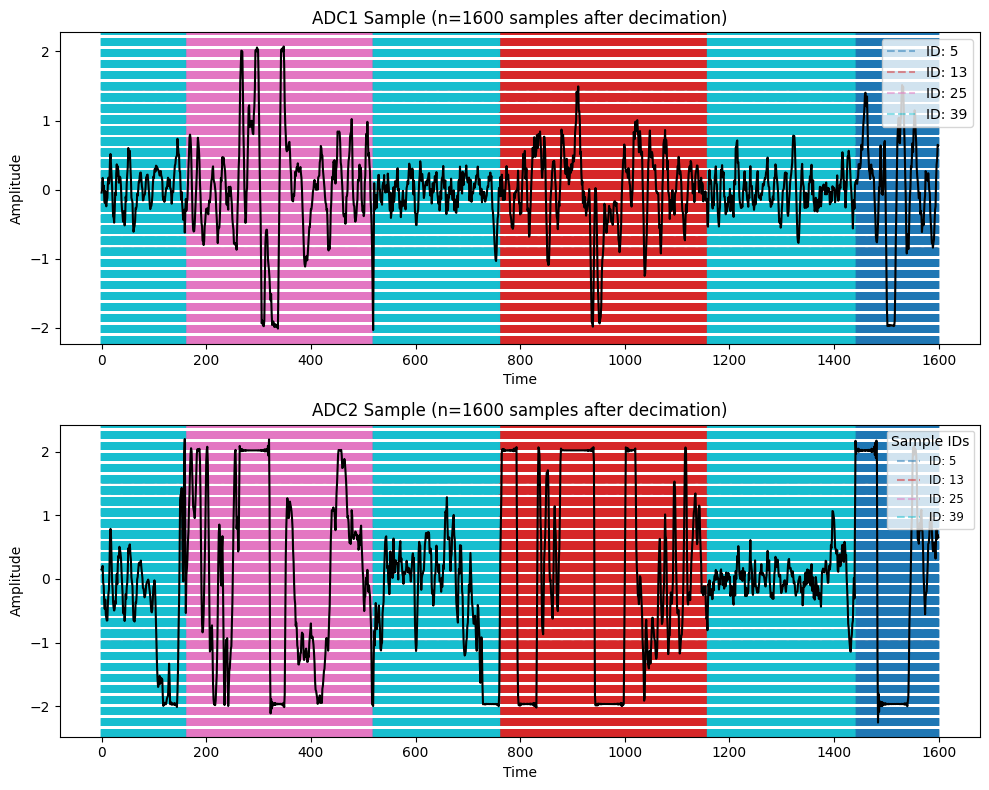

In [3]:
from scipy.signal import decimate

import matplotlib.pyplot as plt

n_decimate = 10  # Decimation factor

rng_index = np.random.randint(0, len(dataset))
sample = dataset[rng_index]

adc1, adc2, sample_id = sample  # unpack the tuple

# Decimate the signals for display
adc1_decimated = decimate(adc1.numpy(), n_decimate, zero_phase=True)
adc2_decimated = decimate(adc2.numpy(), n_decimate, zero_phase=True)
sample_id_decimated = decimate(sample_id.numpy(), n_decimate, zero_phase=True, ftype='iir')

# Create a figure with two subplots for ADC1 and ADC2.
fig, axs = plt.subplots(2, 1, figsize=(10, 8))

# Add colored vertical lines for the sample_id
unique_ids = torch.unique(sample_id)
colors = plt.cm.tab10(np.linspace(0, 1, len(unique_ids)))  # Generate distinct colors for each unique ID

for unique_id, color in zip(unique_ids, colors):
    indices = (sample_id == unique_id).nonzero(as_tuple=True)[0].numpy()  # Get indices for the current ID
    indices_decimated = indices // n_decimate  # Adjust indices for decimation
    for idx in indices_decimated:
        axs[0].axvline(x=idx, color=color, linestyle='--', alpha=0.5, label=f"ID: {unique_id.item()}")
        axs[1].axvline(x=idx, color=color, linestyle='--', alpha=0.5)

# Add legend to the first subplot
handles, labels = axs[0].get_legend_handles_labels()
by_label = dict(zip(labels, handles))  # Remove duplicate labels
axs[0].legend(by_label.values(), by_label.keys(), loc='upper right')
axs[0].plot(adc1_decimated, color='black', label='ADC1')
axs[0].set_title(f"ADC1 Sample (n={len(adc1_decimated)} samples after decimation)")
axs[0].set_xlabel("Time")
axs[0].set_ylabel("Amplitude")

axs[1].legend(by_label.values(), by_label.keys(), loc='upper right', fontsize='small', title="Sample IDs")
axs[1].plot(adc2_decimated, color='black', label='ADC2')
axs[1].set_title(f"ADC2 Sample (n={len(adc2_decimated)} samples after decimation)")
axs[1].set_xlabel("Time")
axs[1].set_ylabel("Amplitude")

plt.tight_layout()
plt.show()


In [4]:
# !pip install torchviz
# !pip install graphviz

In [5]:
from torch import nn
import math
from torchviz import make_dot

def compute_model_size(model, input_tensor):
    """
    Computes the size of the model in MB.
    Args:
        model: The PyTorch model.
        input_tensor: A sample input tensor to pass through the model.
    Returns:
        size_in_mb: Size of the model in MB.
    """
    num_params = sum(p.numel() for p in model.parameters())
    size_in_bytes = num_params * 4  # Assuming float32 (4 bytes)
    size_in_mb = size_in_bytes / (1024 ** 2)
    return size_in_mb

class SinusoidalPositionalEncoding(nn.Module):
    """
    Implements the classic sinusoidal positional encoding as described in the 
    "Attention is All You Need" paper (Vaswani et al., 2017).
    """
    def __init__(self, d_model, max_len=10000):
        super().__init__()
        
        # Create a long enough P x D matrix of sinusoidal signals
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)  # [max_len, 1]
        div_term = torch.exp(
            torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model)
        )  # [d_model/2]
        
        pe = torch.zeros(max_len, d_model)  # [max_len, d_model]
        # Even indices: 2i
        pe[:, 0::2] = torch.sin(position * div_term)
        # Odd indices: 2i+1
        pe[:, 1::2] = torch.cos(position * div_term)
        
        # Register as buffer so it doesn't get updated during backprop
        self.register_buffer("pe", pe)

    def forward(self, x):
        """
        x is assumed to be of shape [batch_size, seq_len, d_model].
        We want to add positional encoding to each position in the sequence.
        """
        seq_len = x.size(1)  # how many tokens in the sequence dimension
        # Add the positional embedding up to seq_len
        pos_emb = self.pe[:seq_len, :]  # shape [seq_len, d_model]
        # We need shape to match x: [B, seq_len, d_model]
        return x + pos_emb.unsqueeze(0)


class V1dTransformer(nn.Module):
    def __init__(self, 
                 input_dim,
                 output_dim,
                 max_length,
                 input_kern = 16,  # Kernel size for the initial Conv1d layer
                 nhead=8, 
                 num_encoder_layers=6, 
                 dim_feedforward=512, 
                 dropout=0.1):
        super(V1dTransformer, self).__init__()
        
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.input_kern = input_kern  # Kernel size for the initial Conv1d layer
        self.stride = input_kern   # Stride for the Conv1d layer, typically half of kernel size
        # conv sequence
        self.conv = nn.Conv1d(input_dim, dim_feedforward//2, kernel_size=self.input_kern, stride=self.stride)
        self.convAcivation = nn.GELU()
        self.conv2 = nn.Conv1d(dim_feedforward//2, dim_feedforward, kernel_size=1)
        # self.posencoding = nn.Embedding(10000, dim_feedforward)  # Positional encoding for up to 1000 positions
        self.pos_encoding = SinusoidalPositionalEncoding(dim_feedforward, max_len=(max_length-self.input_kern)//self.stride + 1)  # Adjust max_len based on stride
        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=dim_feedforward,
                nhead=nhead,
                dim_feedforward=dim_feedforward*2,
                dropout=dropout,
                batch_first=True  # Set to True to match the input shape (batch_size, seq_length, d_model
            ),
            num_layers=num_encoder_layers
        )
        self.fc_out = nn.Linear(dim_feedforward, output_dim)

        # self.special_token = nn.Embedding(1, dim_feedforward)  # Special token embedding for the special token
    
    def forward(self, x):
        """
        x: shape [B, 2, T]  (two ADC channels)
        special_token_positions_batch: list of lists of integers
        - E.g. [[2, 10], [0, 3, 5], ..., [1]] 
        - where each sub-list is for one sample in the batch.
        """

        # 1) Convolution => [B, dim_feedforward, new_seq_len]
        x = self.conv(x)
        x = self.convAcivation(x)
        x = self.conv2(x)
        
        # 2) Permute => [B, new_seq_len, dim_feedforward]
        x = x.permute(0, 2, 1)

        # 4) Add positional encoding => [B, new_seq_len, dim_feedforward]
        x = self.pos_encoding(x)
        
        # 5) Transformer => [B, new_seq_len, dim_feedforward]
        x = self.transformer_encoder(x)

        # 6) Final projection => [B, new_seq_len, output_dim]
        x = self.fc_out(x)

        return x


dummy_input = torch.randn(4,2, seq_length)


model = V1dTransformer(
    input_dim=2,  # Two input channels: adc1 and adc2
    output_dim=dataset.get_N_classes(),  # Number of classes
    max_length=seq_length,  # Maximum sequence length
    input_kern=32,  # Kernel size for the initial Conv1d layer
    nhead=4, 
    num_encoder_layers=2, 
    dim_feedforward=256, 
    dropout=0.1
)


output = model(dummy_input)

print("Output shape:", output.shape)
print("\n\n")
print("Model size (MB):", compute_model_size(model, dummy_input))
print("\nModel summary:\n")
print(model)

make_dot(output, params=dict(list(model.named_parameters()) + (list(model.pos_encoding.named_parameters())))).render("v1dTransformer", format="png")


Output shape: torch.Size([4, 500, 40])



Model size (MB): 4.218414306640625

Model summary:

V1dTransformer(
  (conv): Conv1d(2, 128, kernel_size=(32,), stride=(32,))
  (convAcivation): GELU(approximate='none')
  (conv2): Conv1d(128, 256, kernel_size=(1,), stride=(1,))
  (pos_encoding): SinusoidalPositionalEncoding()
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
        )
        (linear1): Linear(in_features=256, out_features=512, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=512, out_features=256, bias=True)
        (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0

'v1dTransformer.png'

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import random


def train_epoch(
    model,
    dataloader,
    epochs,
    optimizer,
    scheduler,
    loss_func,
    device='cpu',
    min_special_tokens=100,
    max_special_tokens=500,
    verbose=1
):
    model.to(device)
    model.train()

    for epoch in range(epochs):
        total_loss = 0.0
        total_correct = 0
        total_special = 0
        num_batches = 0
        
        # Loop over data
        iterator = tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}", disable=(verbose==0))
        for (adc1, adc2, ids) in iterator:
            # Move to device
            adc1 = adc1.to(device)  # shape [B, T]
            adc2 = adc2.to(device)  # shape [B, T]
            ids = ids.to(device)    # shape [B, T]
            ids = ids[:,::model.input_kern]  # Downsample ids to match the new sequence length after Conv1d
            # print(ids.min(), ids.max(), ids.shape)
            # -------------------------------------------------
            # 2) Stack ADC channels => shape [B, 2, T]
            # -------------------------------------------------
            adc = torch.stack((adc1, adc2), dim=1)  # [B, 2, T]
            adc = adc+torch.randn_like(adc) * 0.02  # Adding a small amount of noise for robustness
            
            # -------------------------------------------------
            # 3) Forward pass
            # -------------------------------------------------
            logits = model(adc)  
            # shape [B, seq_len_after_conv, output_dim]
            # -------------------------------------------------
            # 5) Compute classification loss
            # -------------------------------------------------
            loss = loss_func(logits.permute(0,2,1), ids)
            
            # 6) Backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # 7) Accuracy on these special tokens
            with torch.no_grad():
                pred = logits.argmax(dim=2)  # [N]
                correct = (pred == ids).sum().item()
            
            total_loss += loss.item()
            total_correct += correct
            total_special += logits.size(0)* logits.size(1)  # total number of special tokens processed
            num_batches += 1

            if verbose:
                iterator.set_postfix({
                    "loss": f"{loss.item():.4f}",
                    "acc": f"{100.0 * correct / (logits.size(0)*logits.size(1)):.2f}%",
                })
        scheduler.step()
        # End of epoch
        avg_loss = total_loss / max(num_batches, 1)
        if total_special > 0:
            accuracy = 100.0 * total_correct / total_special
        else:
            accuracy = 0.0
        
        if verbose:
            print(f"Epoch {epoch+1}/{epochs} => Loss: {avg_loss:.4f}, Special-Token Accuracy: {accuracy:.2f}%")
    return avg_loss, accuracy



In [7]:
from torch.utils.data import DataLoader, random_split

# Define the dataset split ratio
train_ratio = 0.8  # 80% for training
val_ratio = 0.2

# Calculate the number of samples for training and validation
train_size = int(train_ratio * len(dataset))
val_size = len(dataset) - train_size

# Split the dataset into training and validation sets
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

#! Create DataLoader instances for training and validation sets
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=True, num_workers=4)

# Sample 100 elements from both training and validation datasets for testing
for i, (ids, adc1, adc2) in enumerate(train_loader):
    print(f"Batch {i+1}:")
    print("IDs:", ids)
    print("ADC1 shape:", adc1.shape)
    print("ADC2 shape:", adc2.shape)
    if i >= 1:  # Stop after the first batch
        break

for i, (ids, adc1, adc2) in enumerate(val_loader):
    print(f"Batch {i+1}:")
    print("IDs:", ids)
    print("ADC1 shape:", adc1.shape)
    print("ADC2 shape:", adc2.shape)
    if i >= 1:  # Stop after the first batch
        break
    


print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(val_dataset)}")


Batch 1:
IDs: tensor([[-0.3997, -0.4184,  0.2940,  ..., -0.5286, -0.2954, -0.5748],
        [-0.0897, -0.1370, -0.1320,  ...,  0.3816, -0.2718, -0.6319],
        [ 0.2979,  0.2674,  0.0077,  ..., -0.0681, -0.0268,  0.0047],
        ...,
        [ 0.8627,  0.1612,  0.0106,  ..., -0.1645, -0.3003, -0.2580],
        [ 0.9306, -0.1173, -0.1173,  ...,  0.0205, -0.1675, -0.1684],
        [-0.0573,  0.1828,  0.0362,  ...,  0.0146,  0.0067, -0.0169]])
ADC1 shape: torch.Size([64, 16000])
ADC2 shape: torch.Size([64, 16000])
Batch 2:
IDs: tensor([[-0.2147, -0.1999,  0.1198,  ...,  1.1559,  0.0795, -0.0150],
        [ 0.1946,  0.5164,  0.2300,  ..., -0.0868,  0.4249, -0.0691],
        [-0.3288, -0.3741, -0.3406,  ...,  0.4278,  0.0264,  0.9276],
        ...,
        [ 0.0411,  0.0028,  0.0362,  ...,  0.2901,  0.8647,  0.3491],
        [ 0.1513,  0.0677,  0.1277,  ..., -0.2570,  0.4770,  0.0028],
        [ 0.2054,  0.1710,  0.0785,  ..., -0.0602, -0.0199,  0.0214]])
ADC1 shape: torch.Size([64, 1600

In [8]:
# !wandb login

In [9]:
# import wandb

# # Initialize W&B
# wandb.init(project="Murmurations")

# # Configure W&B logging
# config = wandb.config
# config.learning_rate = 0.001
# config.epochs = 10
# config.batch_size = 4


In [10]:
TOTAL_EPOCHS = 512
PER_EPOCH = 1

optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
weights = torch.ones(dataset.get_N_classes())  # Weight for each class
weights[-1] = 1/(dataset.get_N_classes()*1.5)  # Give less weight to the noise class
criterion = torch.nn.CrossEntropyLoss(weight=weights, label_smoothing=0.1)  # Use label smoothing for better generalization
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, TOTAL_EPOCHS, eta_min=0.0001)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=3, eta_min=0.0001)
# scheduler = None
if torch.backends.mps.is_available():
    global_device = torch.device("mps")
else:
    global_device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device:", global_device)
verbosity = 1
criterion = criterion.to(global_device)

Using device: cuda:0


In [11]:
# the actual training loop
train_stats = []
test_stats = []
best_accuracy = 0.0  # Initialize the best accuracy

for epoch in tqdm(range(TOTAL_EPOCHS), desc="TOTAL Epochs", disable=(verbosity == 0)):
    res = train_epoch(model, 
                     train_loader, 
                     epochs=PER_EPOCH, 
                     optimizer=optimizer,
                     scheduler=scheduler,
                     loss_func=criterion,
                     device=global_device,
                     min_special_tokens=100,
                     max_special_tokens=1000,
                     verbose=epoch % 10 == 0 
                     )
    train_stats.append(res)
    test_stats.append(res)
    
    # Check if the current accuracy is better than the best accuracy
    current_accuracy = res[1]
    if current_accuracy > best_accuracy:
        best_accuracy = current_accuracy
        torch.save(model.state_dict(), "best_v1dTransformer.pth")  # Save the model
        print(f"New best accuracy: {best_accuracy:.2f}%. Model saved.")


TOTAL Epochs:   0%|          | 1/512 [00:01<09:32,  1.12s/it]

Epoch 1/1 => Loss: 4.0299, Special-Token Accuracy: 1.90%
New best accuracy: 1.90%. Model saved.


TOTAL Epochs:   1%|          | 3/512 [00:02<07:04,  1.20it/s]

New best accuracy: 2.77%. Model saved.


TOTAL Epochs:   1%|          | 4/512 [00:03<06:44,  1.26it/s]

New best accuracy: 3.04%. Model saved.


TOTAL Epochs:   1%|          | 5/512 [00:04<06:33,  1.29it/s]

New best accuracy: 4.34%. Model saved.


TOTAL Epochs:   1%|          | 6/512 [00:04<06:25,  1.31it/s]

New best accuracy: 5.96%. Model saved.


TOTAL Epochs:   1%|▏         | 7/512 [00:05<06:22,  1.32it/s]

New best accuracy: 7.27%. Model saved.


TOTAL Epochs:   2%|▏         | 8/512 [00:06<06:18,  1.33it/s]

New best accuracy: 9.45%. Model saved.


TOTAL Epochs:   2%|▏         | 9/512 [00:07<06:16,  1.34it/s]

New best accuracy: 10.56%. Model saved.


TOTAL Epochs:   2%|▏         | 10/512 [00:07<06:14,  1.34it/s]

New best accuracy: 11.53%. Model saved.


TOTAL Epochs:   2%|▏         | 11/512 [00:08<06:18,  1.33it/s]

Epoch 1/1 => Loss: 3.2338, Special-Token Accuracy: 10.76%


TOTAL Epochs:   2%|▏         | 12/512 [00:09<06:17,  1.33it/s]

New best accuracy: 12.16%. Model saved.


TOTAL Epochs:   3%|▎         | 13/512 [00:10<06:15,  1.33it/s]

New best accuracy: 12.60%. Model saved.


TOTAL Epochs:   3%|▎         | 14/512 [00:10<06:14,  1.33it/s]

New best accuracy: 14.90%. Model saved.


TOTAL Epochs:   3%|▎         | 15/512 [00:11<06:17,  1.32it/s]

New best accuracy: 16.80%. Model saved.


TOTAL Epochs:   3%|▎         | 16/512 [00:12<06:14,  1.32it/s]

New best accuracy: 17.98%. Model saved.


TOTAL Epochs:   3%|▎         | 17/512 [00:13<06:13,  1.33it/s]

New best accuracy: 18.02%. Model saved.


TOTAL Epochs:   4%|▎         | 19/512 [00:14<06:09,  1.34it/s]

New best accuracy: 19.68%. Model saved.


TOTAL Epochs:   4%|▍         | 20/512 [00:15<06:08,  1.34it/s]

New best accuracy: 20.23%. Model saved.


TOTAL Epochs:   4%|▍         | 21/512 [00:16<06:13,  1.32it/s]

Epoch 1/1 => Loss: 2.7547, Special-Token Accuracy: 20.81%
New best accuracy: 20.81%. Model saved.


TOTAL Epochs:   4%|▍         | 22/512 [00:16<06:10,  1.32it/s]

New best accuracy: 22.89%. Model saved.


TOTAL Epochs:   4%|▍         | 23/512 [00:17<06:09,  1.33it/s]

New best accuracy: 23.00%. Model saved.


TOTAL Epochs:   5%|▍         | 24/512 [00:18<06:06,  1.33it/s]

New best accuracy: 25.17%. Model saved.


TOTAL Epochs:   5%|▍         | 25/512 [00:19<06:05,  1.33it/s]

New best accuracy: 26.35%. Model saved.


TOTAL Epochs:   5%|▌         | 26/512 [00:19<06:04,  1.33it/s]

New best accuracy: 26.79%. Model saved.


TOTAL Epochs:   5%|▌         | 27/512 [00:20<06:04,  1.33it/s]

New best accuracy: 29.14%. Model saved.


TOTAL Epochs:   5%|▌         | 28/512 [00:21<06:03,  1.33it/s]

New best accuracy: 29.27%. Model saved.


TOTAL Epochs:   6%|▌         | 29/512 [00:22<06:02,  1.33it/s]

New best accuracy: 29.32%. Model saved.


TOTAL Epochs:   6%|▌         | 30/512 [00:22<06:01,  1.33it/s]

New best accuracy: 29.68%. Model saved.


TOTAL Epochs:   6%|▌         | 31/512 [00:23<06:06,  1.31it/s]

Epoch 1/1 => Loss: 2.3525, Special-Token Accuracy: 32.79%
New best accuracy: 32.79%. Model saved.


TOTAL Epochs:   7%|▋         | 34/512 [00:25<05:59,  1.33it/s]

New best accuracy: 34.08%. Model saved.


TOTAL Epochs:   7%|▋         | 35/512 [00:26<05:58,  1.33it/s]

New best accuracy: 34.50%. Model saved.


TOTAL Epochs:   7%|▋         | 36/512 [00:27<05:56,  1.33it/s]

New best accuracy: 35.18%. Model saved.


TOTAL Epochs:   7%|▋         | 37/512 [00:28<05:52,  1.35it/s]

New best accuracy: 37.21%. Model saved.


TOTAL Epochs:   8%|▊         | 41/512 [00:31<05:46,  1.36it/s]

Epoch 1/1 => Loss: 2.3818, Special-Token Accuracy: 31.56%


TOTAL Epochs:  10%|▉         | 49/512 [00:36<05:38,  1.37it/s]

New best accuracy: 37.31%. Model saved.


TOTAL Epochs:  10%|▉         | 51/512 [00:38<05:42,  1.34it/s]

Epoch 1/1 => Loss: 2.2028, Special-Token Accuracy: 35.64%


TOTAL Epochs:  10%|█         | 52/512 [00:39<05:42,  1.34it/s]

New best accuracy: 37.48%. Model saved.


TOTAL Epochs:  10%|█         | 53/512 [00:39<05:42,  1.34it/s]

New best accuracy: 37.68%. Model saved.


TOTAL Epochs:  11%|█         | 54/512 [00:40<05:41,  1.34it/s]

New best accuracy: 38.57%. Model saved.


TOTAL Epochs:  11%|█         | 55/512 [00:41<05:41,  1.34it/s]

New best accuracy: 39.80%. Model saved.


TOTAL Epochs:  11%|█         | 56/512 [00:42<05:41,  1.34it/s]

New best accuracy: 41.51%. Model saved.


TOTAL Epochs:  12%|█▏        | 59/512 [00:44<05:37,  1.34it/s]

New best accuracy: 41.69%. Model saved.


TOTAL Epochs:  12%|█▏        | 61/512 [00:45<05:40,  1.32it/s]

Epoch 1/1 => Loss: 1.9339, Special-Token Accuracy: 43.91%
New best accuracy: 43.91%. Model saved.


TOTAL Epochs:  12%|█▏        | 62/512 [00:46<05:39,  1.32it/s]

New best accuracy: 44.54%. Model saved.


TOTAL Epochs:  12%|█▏        | 63/512 [00:47<05:38,  1.33it/s]

New best accuracy: 45.19%. Model saved.


TOTAL Epochs:  13%|█▎        | 65/512 [00:48<05:34,  1.33it/s]

New best accuracy: 45.26%. Model saved.


TOTAL Epochs:  13%|█▎        | 66/512 [00:49<05:35,  1.33it/s]

New best accuracy: 45.65%. Model saved.


TOTAL Epochs:  13%|█▎        | 67/512 [00:50<05:34,  1.33it/s]

New best accuracy: 47.27%. Model saved.


TOTAL Epochs:  14%|█▍        | 71/512 [00:53<05:34,  1.32it/s]

Epoch 1/1 => Loss: 1.7440, Special-Token Accuracy: 48.74%
New best accuracy: 48.74%. Model saved.


TOTAL Epochs:  14%|█▍        | 72/512 [00:54<05:33,  1.32it/s]

New best accuracy: 52.29%. Model saved.


TOTAL Epochs:  15%|█▍        | 76/512 [00:57<05:27,  1.33it/s]

New best accuracy: 52.69%. Model saved.


TOTAL Epochs:  15%|█▌        | 78/512 [00:58<05:25,  1.34it/s]

New best accuracy: 53.15%. Model saved.


TOTAL Epochs:  16%|█▌        | 80/512 [01:00<05:21,  1.35it/s]

New best accuracy: 54.28%. Model saved.


TOTAL Epochs:  16%|█▌        | 81/512 [01:00<05:21,  1.34it/s]

Epoch 1/1 => Loss: 1.5879, Special-Token Accuracy: 55.20%
New best accuracy: 55.20%. Model saved.


TOTAL Epochs:  16%|█▋        | 84/512 [01:03<05:12,  1.37it/s]

New best accuracy: 57.95%. Model saved.


TOTAL Epochs:  17%|█▋        | 87/512 [01:05<05:08,  1.38it/s]

New best accuracy: 58.39%. Model saved.


TOTAL Epochs:  18%|█▊        | 91/512 [01:08<05:11,  1.35it/s]

Epoch 1/1 => Loss: 1.4818, Special-Token Accuracy: 58.64%
New best accuracy: 58.64%. Model saved.


TOTAL Epochs:  18%|█▊        | 92/512 [01:08<05:11,  1.35it/s]

New best accuracy: 59.76%. Model saved.


TOTAL Epochs:  18%|█▊        | 94/512 [01:10<05:09,  1.35it/s]

New best accuracy: 60.44%. Model saved.


TOTAL Epochs:  19%|█▉        | 96/512 [01:11<05:07,  1.35it/s]

New best accuracy: 60.62%. Model saved.


TOTAL Epochs:  20%|█▉        | 100/512 [01:14<05:06,  1.35it/s]

New best accuracy: 61.97%. Model saved.


TOTAL Epochs:  20%|█▉        | 101/512 [01:15<05:08,  1.33it/s]

Epoch 1/1 => Loss: 1.4180, Special-Token Accuracy: 61.08%


TOTAL Epochs:  20%|██        | 103/512 [01:17<05:05,  1.34it/s]

New best accuracy: 62.38%. Model saved.


TOTAL Epochs:  21%|██        | 106/512 [01:19<05:03,  1.34it/s]

New best accuracy: 63.07%. Model saved.


TOTAL Epochs:  21%|██        | 107/512 [01:20<05:03,  1.33it/s]

New best accuracy: 64.10%. Model saved.


TOTAL Epochs:  22%|██▏       | 111/512 [01:23<05:01,  1.33it/s]

Epoch 1/1 => Loss: 1.3567, Special-Token Accuracy: 62.64%


TOTAL Epochs:  22%|██▏       | 112/512 [01:23<05:00,  1.33it/s]

New best accuracy: 64.19%. Model saved.


TOTAL Epochs:  22%|██▏       | 114/512 [01:25<04:58,  1.34it/s]

New best accuracy: 64.58%. Model saved.


TOTAL Epochs:  22%|██▏       | 115/512 [01:26<04:57,  1.34it/s]

New best accuracy: 64.92%. Model saved.


TOTAL Epochs:  24%|██▎       | 121/512 [01:30<04:54,  1.33it/s]

Epoch 1/1 => Loss: 1.3516, Special-Token Accuracy: 63.37%


TOTAL Epochs:  24%|██▍       | 124/512 [01:32<04:46,  1.36it/s]

New best accuracy: 65.80%. Model saved.


TOTAL Epochs:  25%|██▌       | 128/512 [01:35<04:39,  1.38it/s]

New best accuracy: 65.83%. Model saved.


TOTAL Epochs:  26%|██▌       | 131/512 [01:37<04:41,  1.35it/s]

Epoch 1/1 => Loss: 1.4378, Special-Token Accuracy: 61.29%


TOTAL Epochs:  28%|██▊       | 141/512 [01:45<04:36,  1.34it/s]

Epoch 1/1 => Loss: 1.4283, Special-Token Accuracy: 61.22%


TOTAL Epochs:  29%|██▉       | 151/512 [01:52<04:31,  1.33it/s]

Epoch 1/1 => Loss: 1.3449, Special-Token Accuracy: 63.03%


TOTAL Epochs:  31%|███       | 158/512 [01:57<04:24,  1.34it/s]

New best accuracy: 66.80%. Model saved.


TOTAL Epochs:  31%|███▏      | 161/512 [02:00<04:26,  1.32it/s]

Epoch 1/1 => Loss: 1.2614, Special-Token Accuracy: 67.18%
New best accuracy: 67.18%. Model saved.


TOTAL Epochs:  32%|███▏      | 162/512 [02:00<04:25,  1.32it/s]

New best accuracy: 68.92%. Model saved.


TOTAL Epochs:  32%|███▏      | 166/512 [02:03<04:20,  1.33it/s]

New best accuracy: 69.02%. Model saved.


TOTAL Epochs:  33%|███▎      | 167/512 [02:04<04:17,  1.34it/s]

New best accuracy: 69.19%. Model saved.


TOTAL Epochs:  33%|███▎      | 169/512 [02:06<04:12,  1.36it/s]

New best accuracy: 69.21%. Model saved.


TOTAL Epochs:  33%|███▎      | 171/512 [02:07<04:12,  1.35it/s]

Epoch 1/1 => Loss: 1.2114, Special-Token Accuracy: 69.71%
New best accuracy: 69.71%. Model saved.


TOTAL Epochs:  34%|███▎      | 172/512 [02:08<04:11,  1.35it/s]

New best accuracy: 69.94%. Model saved.


TOTAL Epochs:  35%|███▍      | 177/512 [02:11<04:06,  1.36it/s]

New best accuracy: 70.20%. Model saved.


TOTAL Epochs:  35%|███▍      | 178/512 [02:12<04:06,  1.35it/s]

New best accuracy: 70.78%. Model saved.


TOTAL Epochs:  35%|███▌      | 180/512 [02:14<04:05,  1.35it/s]

New best accuracy: 71.48%. Model saved.


TOTAL Epochs:  35%|███▌      | 181/512 [02:14<04:07,  1.34it/s]

Epoch 1/1 => Loss: 1.1743, Special-Token Accuracy: 70.50%


TOTAL Epochs:  36%|███▋      | 186/512 [02:18<04:01,  1.35it/s]

New best accuracy: 72.09%. Model saved.


TOTAL Epochs:  37%|███▋      | 190/512 [02:21<03:59,  1.34it/s]

New best accuracy: 72.52%. Model saved.


TOTAL Epochs:  37%|███▋      | 191/512 [02:22<04:02,  1.32it/s]

Epoch 1/1 => Loss: 1.1556, Special-Token Accuracy: 70.66%


TOTAL Epochs:  38%|███▊      | 192/512 [02:23<04:01,  1.33it/s]

New best accuracy: 72.61%. Model saved.


TOTAL Epochs:  38%|███▊      | 194/512 [02:24<03:59,  1.33it/s]

New best accuracy: 73.16%. Model saved.


TOTAL Epochs:  39%|███▉      | 199/512 [02:28<03:52,  1.34it/s]

New best accuracy: 73.38%. Model saved.


TOTAL Epochs:  39%|███▉      | 200/512 [02:29<03:53,  1.33it/s]

New best accuracy: 73.43%. Model saved.


TOTAL Epochs:  39%|███▉      | 201/512 [02:29<03:55,  1.32it/s]

Epoch 1/1 => Loss: 1.1513, Special-Token Accuracy: 72.84%


TOTAL Epochs:  40%|████      | 207/512 [02:34<03:47,  1.34it/s]

New best accuracy: 74.24%. Model saved.


TOTAL Epochs:  41%|████      | 211/512 [02:37<03:42,  1.35it/s]

Epoch 1/1 => Loss: 1.1188, Special-Token Accuracy: 73.56%


TOTAL Epochs:  41%|████▏     | 212/512 [02:37<03:41,  1.36it/s]

New best accuracy: 74.40%. Model saved.


TOTAL Epochs:  42%|████▏     | 215/512 [02:40<03:36,  1.37it/s]

New best accuracy: 75.12%. Model saved.


TOTAL Epochs:  42%|████▏     | 217/512 [02:41<03:37,  1.36it/s]

New best accuracy: 75.36%. Model saved.


TOTAL Epochs:  43%|████▎     | 221/512 [02:44<03:37,  1.34it/s]

Epoch 1/1 => Loss: 1.1034, Special-Token Accuracy: 75.60%
New best accuracy: 75.60%. Model saved.


TOTAL Epochs:  44%|████▍     | 224/512 [02:46<03:32,  1.35it/s]

New best accuracy: 75.93%. Model saved.


TOTAL Epochs:  45%|████▍     | 230/512 [02:51<03:27,  1.36it/s]

New best accuracy: 76.51%. Model saved.


TOTAL Epochs:  45%|████▌     | 231/512 [02:52<03:30,  1.33it/s]

Epoch 1/1 => Loss: 1.0905, Special-Token Accuracy: 75.64%


TOTAL Epochs:  47%|████▋     | 241/512 [02:59<03:25,  1.32it/s]

Epoch 1/1 => Loss: 1.0869, Special-Token Accuracy: 76.62%
New best accuracy: 76.62%. Model saved.


TOTAL Epochs:  48%|████▊     | 244/512 [03:01<03:22,  1.32it/s]

New best accuracy: 77.20%. Model saved.


TOTAL Epochs:  48%|████▊     | 246/512 [03:03<03:20,  1.33it/s]

New best accuracy: 77.33%. Model saved.


TOTAL Epochs:  49%|████▉     | 251/512 [03:07<03:17,  1.32it/s]

Epoch 1/1 => Loss: 1.0826, Special-Token Accuracy: 77.32%


TOTAL Epochs:  49%|████▉     | 252/512 [03:07<03:16,  1.33it/s]

New best accuracy: 77.41%. Model saved.


TOTAL Epochs:  49%|████▉     | 253/512 [03:08<03:16,  1.32it/s]

New best accuracy: 77.52%. Model saved.


TOTAL Epochs:  50%|████▉     | 254/512 [03:09<03:13,  1.33it/s]

New best accuracy: 77.76%. Model saved.


TOTAL Epochs:  50%|█████     | 258/512 [03:12<03:05,  1.37it/s]

New best accuracy: 78.20%. Model saved.


TOTAL Epochs:  51%|█████     | 261/512 [03:14<03:05,  1.36it/s]

Epoch 1/1 => Loss: 1.0699, Special-Token Accuracy: 77.63%


TOTAL Epochs:  51%|█████     | 262/512 [03:15<03:04,  1.36it/s]

New best accuracy: 78.24%. Model saved.


TOTAL Epochs:  52%|█████▏    | 267/512 [03:18<03:00,  1.36it/s]

New best accuracy: 78.70%. Model saved.


TOTAL Epochs:  53%|█████▎    | 271/512 [03:21<03:00,  1.34it/s]

Epoch 1/1 => Loss: 1.0701, Special-Token Accuracy: 78.43%


TOTAL Epochs:  53%|█████▎    | 273/512 [03:23<02:58,  1.34it/s]

New best accuracy: 78.79%. Model saved.


TOTAL Epochs:  54%|█████▎    | 274/512 [03:23<02:57,  1.34it/s]

New best accuracy: 78.80%. Model saved.


TOTAL Epochs:  54%|█████▍    | 276/512 [03:25<02:56,  1.34it/s]

New best accuracy: 79.34%. Model saved.


TOTAL Epochs:  55%|█████▍    | 281/512 [03:29<02:54,  1.32it/s]

Epoch 1/1 => Loss: 1.0550, Special-Token Accuracy: 78.75%


TOTAL Epochs:  57%|█████▋    | 291/512 [03:36<02:47,  1.32it/s]

Epoch 1/1 => Loss: 1.0564, Special-Token Accuracy: 79.75%
New best accuracy: 79.75%. Model saved.


TOTAL Epochs:  59%|█████▊    | 300/512 [03:43<02:34,  1.37it/s]

New best accuracy: 79.81%. Model saved.


TOTAL Epochs:  59%|█████▉    | 301/512 [03:44<02:36,  1.35it/s]

Epoch 1/1 => Loss: 1.0436, Special-Token Accuracy: 80.02%
New best accuracy: 80.02%. Model saved.


TOTAL Epochs:  59%|█████▉    | 302/512 [03:44<02:35,  1.35it/s]

New best accuracy: 80.22%. Model saved.


TOTAL Epochs:  59%|█████▉    | 304/512 [03:46<02:33,  1.36it/s]

New best accuracy: 80.45%. Model saved.


TOTAL Epochs:  60%|██████    | 308/512 [03:49<02:30,  1.36it/s]

New best accuracy: 80.86%. Model saved.


TOTAL Epochs:  61%|██████    | 311/512 [03:51<02:29,  1.34it/s]

Epoch 1/1 => Loss: 1.0413, Special-Token Accuracy: 79.71%


TOTAL Epochs:  63%|██████▎   | 321/512 [03:58<02:23,  1.33it/s]

Epoch 1/1 => Loss: 1.0435, Special-Token Accuracy: 80.63%


TOTAL Epochs:  63%|██████▎   | 324/512 [04:01<02:21,  1.33it/s]

New best accuracy: 80.95%. Model saved.


TOTAL Epochs:  65%|██████▍   | 331/512 [04:06<02:17,  1.32it/s]

Epoch 1/1 => Loss: 1.0293, Special-Token Accuracy: 81.27%
New best accuracy: 81.27%. Model saved.


TOTAL Epochs:  66%|██████▌   | 336/512 [04:10<02:11,  1.33it/s]

New best accuracy: 81.31%. Model saved.


TOTAL Epochs:  67%|██████▋   | 341/512 [04:13<02:07,  1.34it/s]

Epoch 1/1 => Loss: 1.0344, Special-Token Accuracy: 81.00%


TOTAL Epochs:  68%|██████▊   | 347/512 [04:18<02:00,  1.37it/s]

New best accuracy: 81.66%. Model saved.


TOTAL Epochs:  69%|██████▊   | 351/512 [04:21<01:59,  1.35it/s]

Epoch 1/1 => Loss: 1.0314, Special-Token Accuracy: 81.24%


TOTAL Epochs:  70%|███████   | 360/512 [04:27<01:52,  1.35it/s]

New best accuracy: 82.13%. Model saved.


TOTAL Epochs:  71%|███████   | 361/512 [04:28<01:53,  1.33it/s]

Epoch 1/1 => Loss: 1.0292, Special-Token Accuracy: 81.59%


TOTAL Epochs:  72%|███████▏  | 371/512 [04:35<01:46,  1.33it/s]

Epoch 1/1 => Loss: 1.0332, Special-Token Accuracy: 80.41%


TOTAL Epochs:  74%|███████▍  | 379/512 [04:41<01:38,  1.35it/s]

New best accuracy: 82.17%. Model saved.


TOTAL Epochs:  74%|███████▍  | 381/512 [04:43<01:38,  1.33it/s]

Epoch 1/1 => Loss: 1.0221, Special-Token Accuracy: 82.06%


TOTAL Epochs:  76%|███████▋  | 391/512 [04:50<01:28,  1.36it/s]

Epoch 1/1 => Loss: 1.0302, Special-Token Accuracy: 81.69%


TOTAL Epochs:  77%|███████▋  | 393/512 [04:52<01:27,  1.36it/s]

New best accuracy: 82.59%. Model saved.


TOTAL Epochs:  78%|███████▊  | 398/512 [04:55<01:23,  1.36it/s]

New best accuracy: 82.77%. Model saved.


TOTAL Epochs:  78%|███████▊  | 401/512 [04:58<01:22,  1.35it/s]

Epoch 1/1 => Loss: 1.0462, Special-Token Accuracy: 81.01%


TOTAL Epochs:  80%|████████  | 411/512 [05:05<01:15,  1.33it/s]

Epoch 1/1 => Loss: 1.2289, Special-Token Accuracy: 69.41%


TOTAL Epochs:  82%|████████▏ | 421/512 [05:12<01:08,  1.33it/s]

Epoch 1/1 => Loss: 1.1474, Special-Token Accuracy: 73.84%


TOTAL Epochs:  84%|████████▍ | 431/512 [05:20<00:59,  1.36it/s]

Epoch 1/1 => Loss: 1.0974, Special-Token Accuracy: 76.51%


TOTAL Epochs:  86%|████████▌ | 441/512 [05:27<00:52,  1.35it/s]

Epoch 1/1 => Loss: 1.0897, Special-Token Accuracy: 77.09%


TOTAL Epochs:  88%|████████▊ | 451/512 [05:34<00:45,  1.33it/s]

Epoch 1/1 => Loss: 1.0600, Special-Token Accuracy: 78.48%


TOTAL Epochs:  90%|█████████ | 461/512 [05:42<00:38,  1.32it/s]

Epoch 1/1 => Loss: 1.0616, Special-Token Accuracy: 78.51%


TOTAL Epochs:  92%|█████████▏| 471/512 [05:49<00:30,  1.32it/s]

Epoch 1/1 => Loss: 1.0580, Special-Token Accuracy: 79.15%


TOTAL Epochs:  94%|█████████▍| 481/512 [05:57<00:22,  1.35it/s]

Epoch 1/1 => Loss: 1.0502, Special-Token Accuracy: 80.11%


TOTAL Epochs:  96%|█████████▌| 491/512 [06:04<00:15,  1.34it/s]

Epoch 1/1 => Loss: 1.0517, Special-Token Accuracy: 79.46%


TOTAL Epochs:  98%|█████████▊| 501/512 [06:12<00:08,  1.33it/s]

Epoch 1/1 => Loss: 1.0447, Special-Token Accuracy: 80.42%


TOTAL Epochs: 100%|█████████▉| 511/512 [06:19<00:00,  1.32it/s]

Epoch 1/1 => Loss: 1.0718, Special-Token Accuracy: 78.65%


TOTAL Epochs: 100%|██████████| 512/512 [06:20<00:00,  1.35it/s]


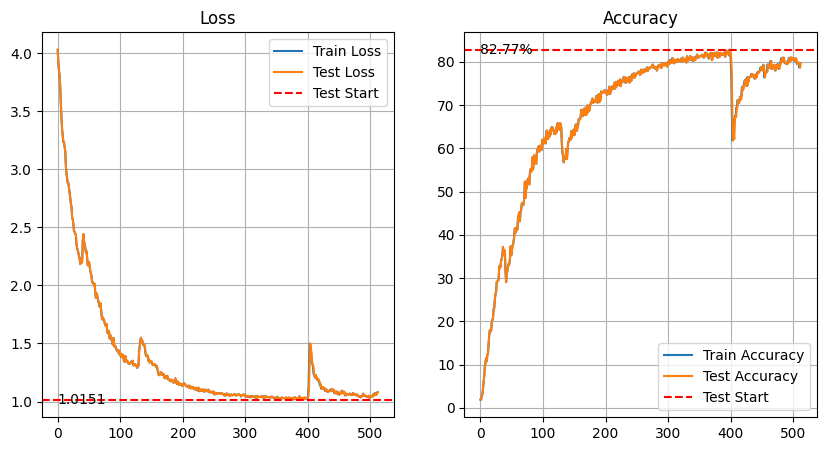

In [12]:
# plot the training and testing loss and accuracy
train_loss = [stat[0] for stat in train_stats]
train_acc =  [stat[1] for stat in train_stats]
test_loss =  [stat[0] for stat in test_stats]
test_acc =   [stat[1] for stat in test_stats]
x_test = np.linspace(0, len(train_loss), len(test_loss))
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Train Loss')
plt.plot(x_test, test_loss, label='Test Loss')
plt.axhline(np.min(test_loss), color='r', linestyle='--', label='Test Start')
plt.text(0, np.min(test_loss), f"{np.min(test_loss):.4f}", va='center', ha='left')
plt.title('Loss')
plt.grid()
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Train Accuracy')
plt.plot(x_test, test_acc, label='Test Accuracy')
plt.axhline(np.max(test_acc), color='r', linestyle='--', label='Test Start')
plt.text(0, np.max(test_acc), f"{np.max(test_acc):.2f}%", va='center', ha='left')
plt.title('Accuracy')
plt.grid()
plt.legend()
plt.show()
peak_accuracy = np.max(test_acc)

In [13]:
# Load the best model's state dictionary
model.load_state_dict(torch.load("best_v1dTransformer.pth"))

# Move the model to the appropriate device
model.to(global_device)

print("Best model loaded successfully.")

Best model loaded successfully.


Evaluating: 100%|██████████| 2/2 [00:00<00:00, 10.50it/s, loss=1.1903, acc=80.93%]


[EVAL] => Time: 0.19s, Avg time per seq: 0.0967s
[EVAL] => Loss: 1.1818, Accuracy: 81.25%
[VALID] Loss: 1.1818, Accuracy: 81.25%
Confusion Matrix:
 [[  811     0     0 ...     0     0     3]
 [    0  1169     0 ...     0     0    13]
 [    0     0  1238 ...     0     0     1]
 ...
 [    0     0     0 ...  1336     0     0]
 [    0     0     0 ...     0  1125     0]
 [  317   314   424 ...   276   465 14424]]


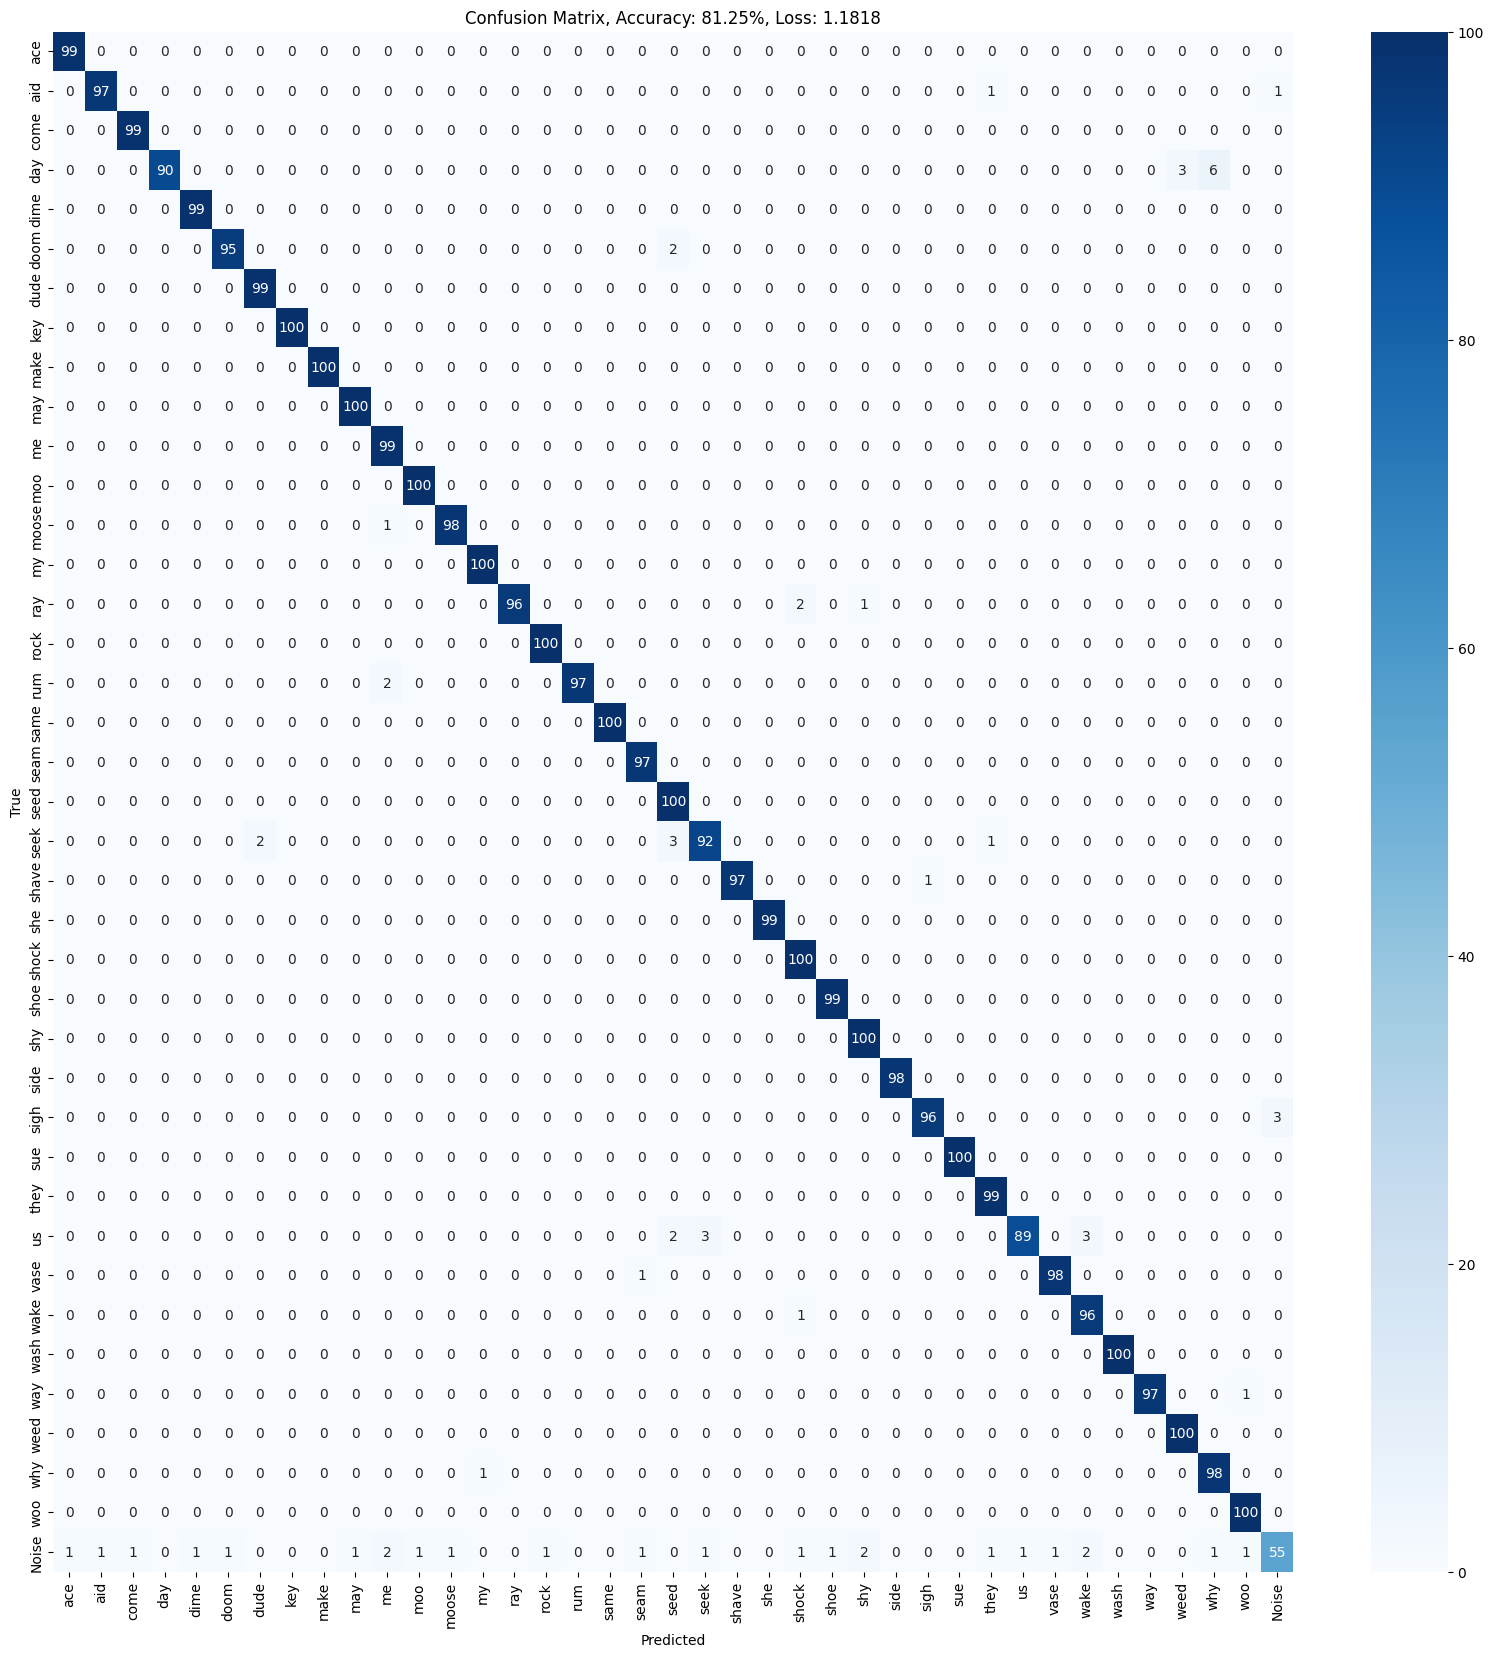

In [14]:
import time
import torch.nn.functional as F
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_epoch(
    model,
    dataloader,
    dataset,  # used for `id_to_dataset()`
    device='cpu',
    verbose=1
):
    """
    Evaluate `model` for 1 epoch on `dataloader`, following the same strategy
    as the new training loop:

    - Downsample `ids` by `model.input_kern` (to match conv-downsampled length).
    - Forward pass on entire sequence to obtain [B, seq_len_after_conv, output_dim].
    - Compute cross-entropy loss on the entire output sequence.
    - Accumulate predictions vs. targets for final confusion matrix.
    - Return (avg_loss, accuracy, confusion_matrix).
    """
    model.to(device)
    model.eval()

    all_labels = []
    all_preds = []
    total_loss = 0.0
    total_correct = 0
    total_tokens = 0
    num_batches = 0
    start_time = time.time()
    with torch.no_grad():
        iterator = tqdm(dataloader, desc="Evaluating", disable=(verbose == 0))
        for (adc1, adc2, ids) in iterator:
            # Move data to device
            adc1 = adc1.to(device)  # shape [B, T]
            adc2 = adc2.to(device)  # shape [B, T]
            ids  = ids.to(device)   # shape [B, T]

            # Downsample `ids` to match logits' length
            ids = ids[:, ::model.input_kern]  # shape [B, T_after_conv]

            # Prepare input: stack the two ADC channels => [B, 2, T]
            adc = torch.stack((adc1, adc2), dim=1)  # [B, 2, T]

            # Forward pass
            logits = model(adc)  # => [B, seq_len_after_conv, output_dim]

            # Compute loss
            loss = F.cross_entropy(
                logits.permute(0, 2, 1),  # => [B, output_dim, seq_len_after_conv]
                ids                       # => [B, seq_len_after_conv]
            )

            # Predictions & accuracy
            pred = logits.argmax(dim=2)  # => [B, seq_len_after_conv]
            correct = (pred == ids).sum().item()
            batch_tokens = ids.numel()

            total_loss += loss.item()
            total_correct += correct
            total_tokens += batch_tokens
            num_batches += 1

            # Accumulate for confusion matrix
            all_labels.extend(ids.view(-1).cpu().tolist())
            all_preds.extend(pred.view(-1).cpu().tolist())

            if verbose:
                iterator.set_postfix({
                    "loss": f"{loss.item():.4f}",
                    "acc": f"{100.0 * correct / batch_tokens:.2f}%"
                })
    end_time = time.time()
    total_time = end_time - start_time
    total_sequences = len(dataloader.dataset)//dataloader.batch_size
    avg_time_per_seq = total_time / total_sequences
    if verbose:
        print(f"[EVAL] => Time: {total_time:.2f}s, Avg time per seq: {avg_time_per_seq:.4f}s")
    # Final stats
    avg_loss = total_loss / max(num_batches, 1)
    accuracy = 100.0 * total_correct / total_tokens if total_tokens > 0 else 0.0

    # Build confusion matrix
    conf_mat = confusion_matrix(all_labels, all_preds)

    if verbose:
        print(f"[EVAL] => Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")

    return avg_loss, accuracy, conf_mat


# Example usage:
avg_loss, accuracy, conf_mat = evaluate_epoch(model, val_loader, dataset=dataset, device='cuda', verbose=1)
print(f"[VALID] Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")
print("Confusion Matrix:\n", conf_mat)

# Build label names from your dataset
# Usually, you'd need the number of classes from something like `model.output_dim`,
# or from the shape of `conf_mat`. We'll assume conf_mat is square CxC, so:
num_classes = conf_mat.shape[0]
label_names = [dataset.id_to_dataset(i) for i in range(num_classes)]

# normalize the confusion matrix per class
conf_mat = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]
# Replace NaN values with 0
conf_mat[np.isnan(conf_mat)] = 0.0
conf_mat = (conf_mat * 100).astype(int)

# Plot the confusion matrix with class names
plt.figure(figsize=(20, 20))
sns.heatmap(
    conf_mat,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=label_names,
    yticklabels=label_names
)
plt.title(f'Confusion Matrix, Accuracy: {accuracy:.2f}%, Loss: {avg_loss:.4f}')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


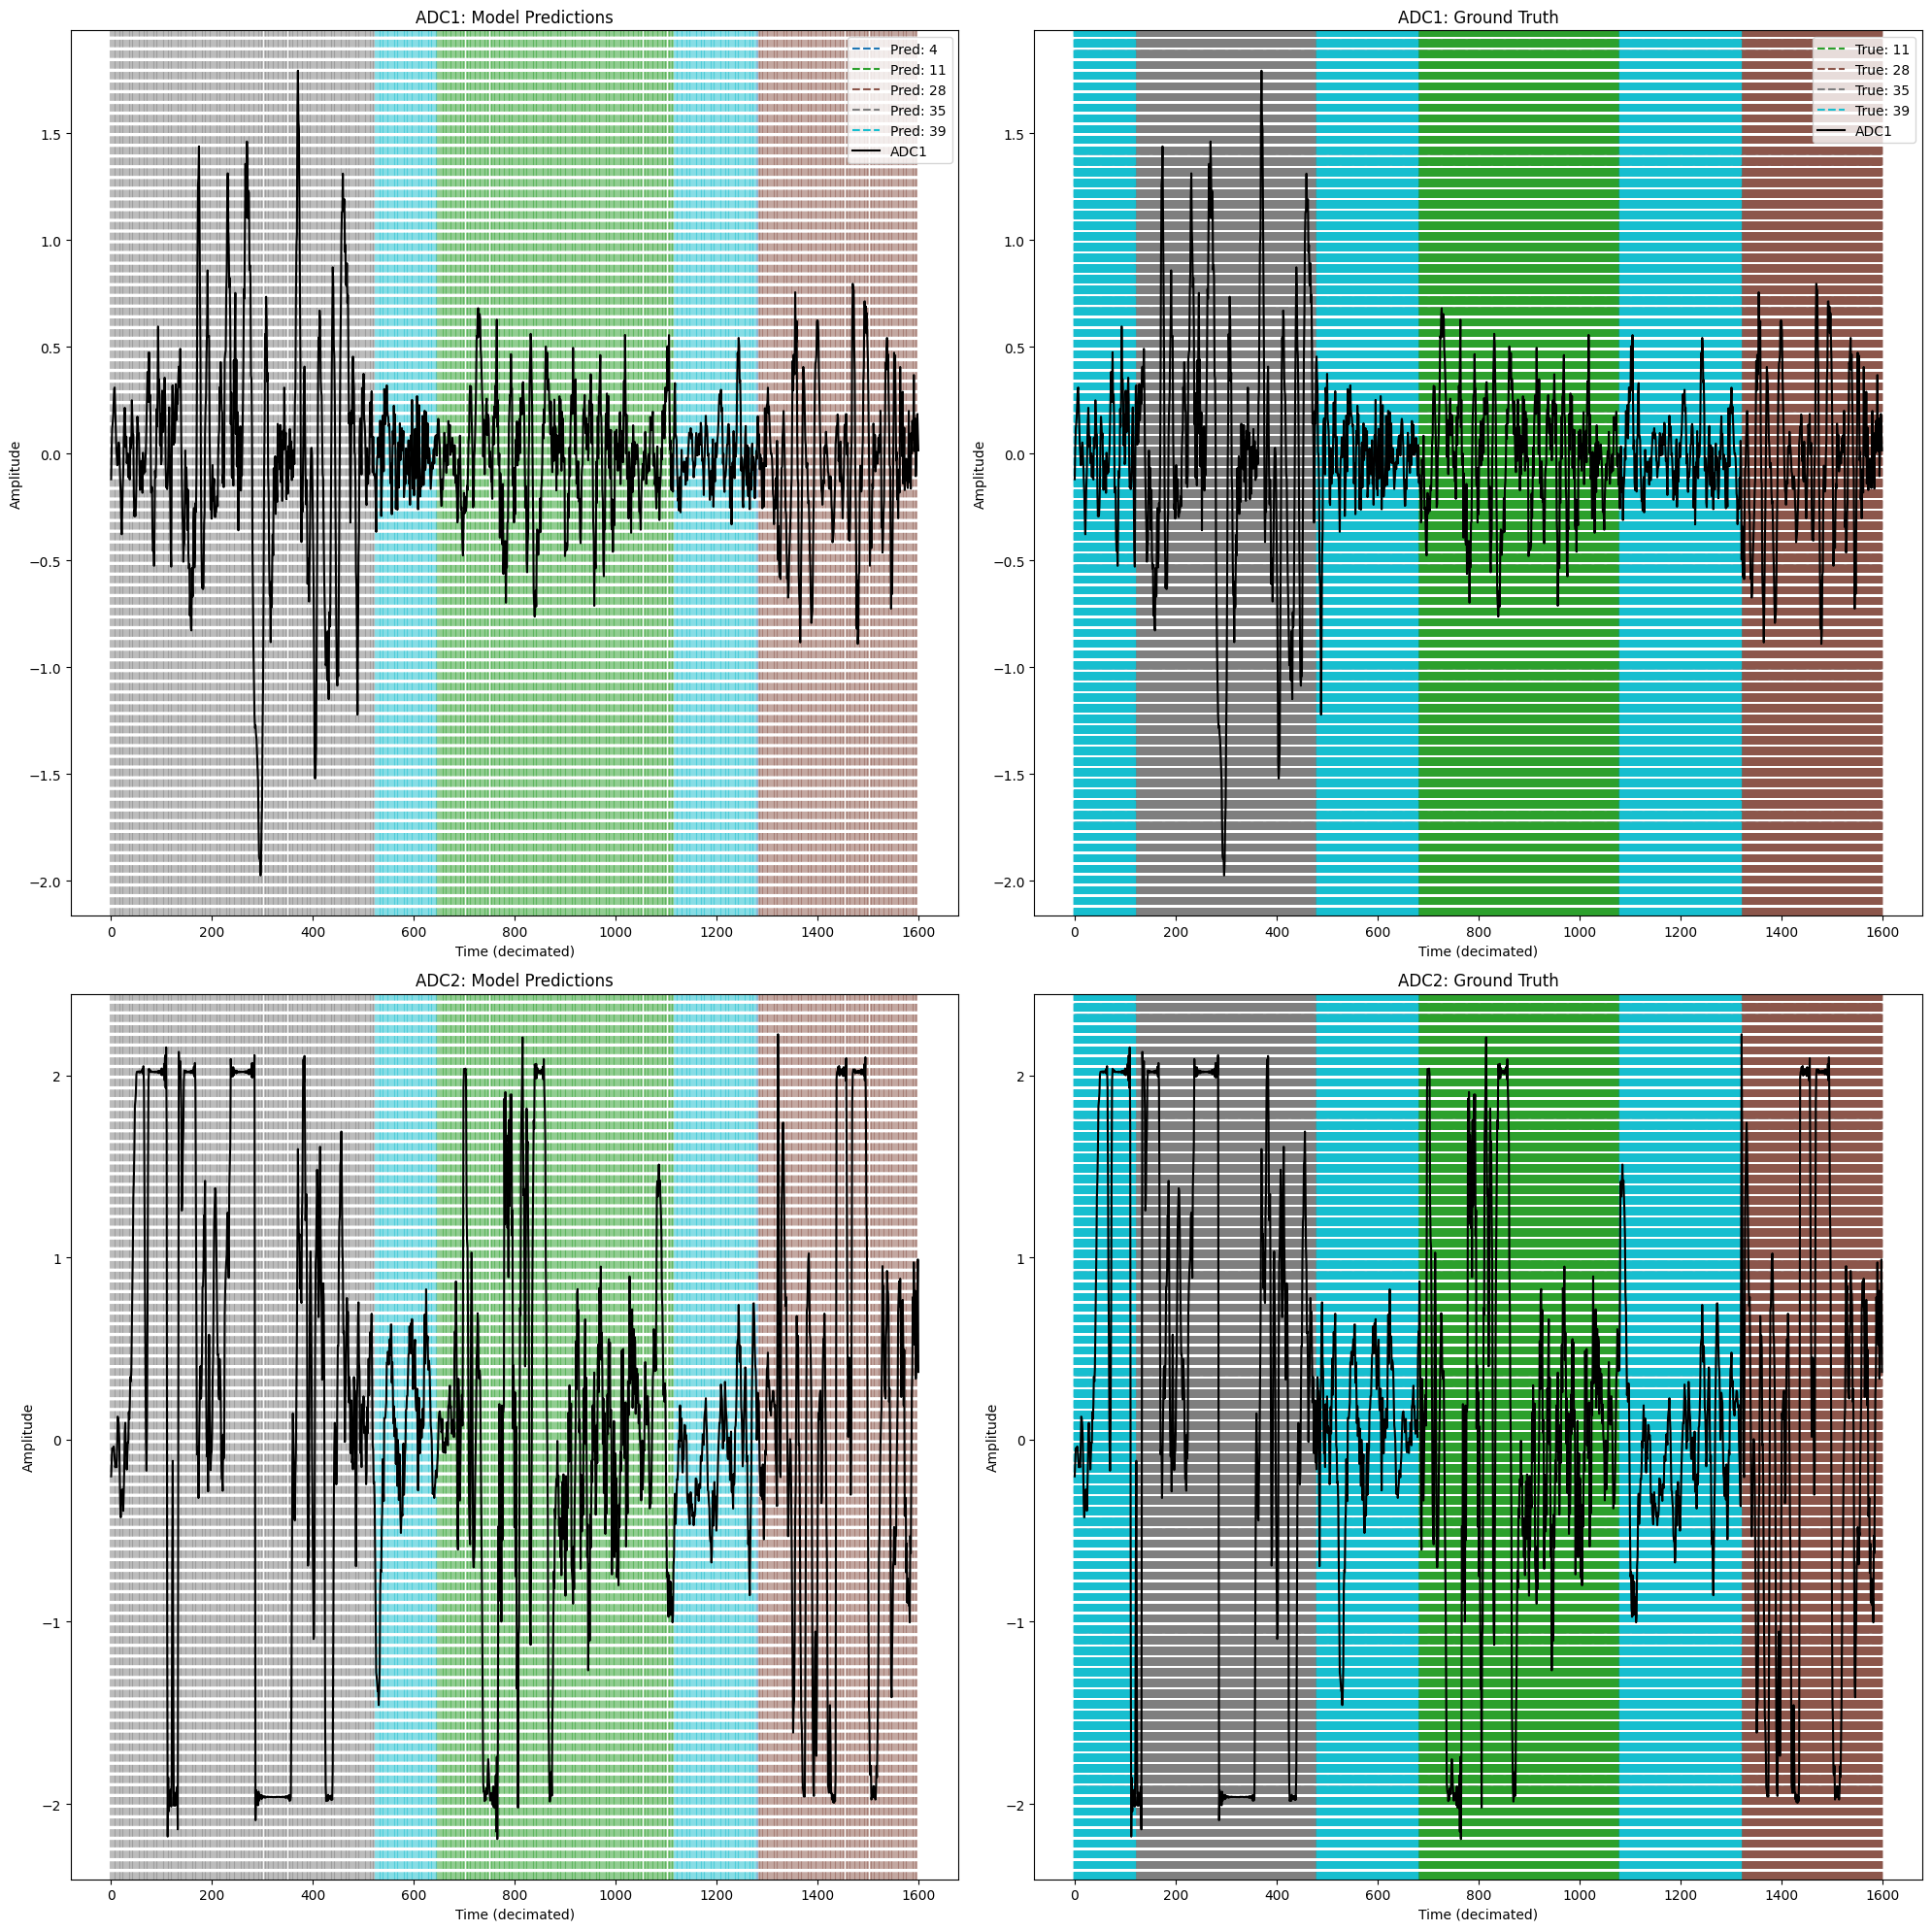

In [15]:
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from scipy.signal import decimate

def visualize_model_predictions_with_groundtruth(model, dataset, device='cpu', n_decimate=10):
    """
    Visualize a random sample's signals (ADC1, ADC2) alongside
    1) the model's predicted labels (left column)
    2) the ground truth labels (right column)
    over time (shown as vertical lines), using consistent colors
    for the same class labels in both subplots.
    """
    model.eval()
    model.to(device)

    # Pick a random sample
    rng_index = np.random.randint(0, len(dataset))
    adc1, adc2, true_ids = dataset[rng_index]  # (Tensor, Tensor, Tensor) or similar

    # Convert signals to batch form: [B=1, 2, T]
    adc = torch.stack((adc1, adc2), dim=0).unsqueeze(0).to(device)  # shape: [1, 2, T]

    # Forward pass => [1, T_after_conv, output_dim]
    with torch.no_grad():
        logits = model(adc)
        # Argmax => [1, T_after_conv]
        pred = logits.argmax(dim=-1).squeeze(0).cpu()  # shape: [T_after_conv]

    # Decimate the signals for display
    adc1_decimated = decimate(adc1.numpy(), n_decimate, zero_phase=True)
    adc2_decimated = decimate(adc2.numpy(), n_decimate, zero_phase=True)

    # Grab unique IDs from both prediction and ground truth
    unique_preds = torch.unique(pred).numpy()
    true_ids_np = true_ids.numpy()
    unique_gts = np.unique(true_ids_np)

    # Build a combined sorted list of all possible IDs
    all_ids = np.unique(np.concatenate([unique_preds, unique_gts]))
    all_ids_sorted = sorted(all_ids)

    # Assign a color to each possible ID using a single shared colormap
    # (you can choose any colormap, e.g. tab10, Set1, etc.)
    color_palette = plt.cm.tab10(np.linspace(0, 1, len(all_ids_sorted)))
    id_to_color = {id_val: color_palette[i] for i, id_val in enumerate(all_ids_sorted)}

    # Create a figure with 2 rows and 2 columns:
    #   Left column = predictions
    #   Right column = ground truth
    fig, axs = plt.subplots(2, 2, figsize=(20, 20), sharex=False, sharey=False)

    # ------------------------------------------------------------------
    # LEFT COLUMN: MODEL PREDICTIONS
    # ------------------------------------------------------------------
    for pred_id in np.unique(pred):
        color = id_to_color[pred_id.item()]
        # Indices where pred == pred_id
        indices = (pred == pred_id).nonzero().flatten().cpu().numpy()
        # Map those indices to decimated plotting coordinates
        decimated_indices = (indices * getattr(model, 'input_kern', 1)) // n_decimate

        # Add vertical lines in both ADC1 and ADC2 subplots (left column)
        for idx in decimated_indices:
            axs[0, 0].axvline(x=idx, color=color, linestyle='--', alpha=0.5)
            axs[1, 0].axvline(x=idx, color=color, linestyle='--', alpha=0.5)

        # Add a "dummy" line for the legend entry
        axs[0, 0].plot([], [], color=color, linestyle='--', label=f"Pred: {pred_id.item()}")

    # Plot decimated signals in the left column
    axs[0, 0].plot(adc1_decimated, color='black', label='ADC1')
    axs[0, 0].set_title("ADC1: Model Predictions")
    axs[0, 0].set_xlabel("Time (decimated)")
    axs[0, 0].set_ylabel("Amplitude")

    axs[1, 0].plot(adc2_decimated, color='black', label='ADC2')
    axs[1, 0].set_title("ADC2: Model Predictions")
    axs[1, 0].set_xlabel("Time (decimated)")
    axs[1, 0].set_ylabel("Amplitude")

    # Consolidate legend in top-left plot
    handles, labels = axs[0, 0].get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    axs[0, 0].legend(by_label.values(), by_label.keys(), loc='upper right')

    # ------------------------------------------------------------------
    # RIGHT COLUMN: GROUND TRUTH LABELS
    # ------------------------------------------------------------------
    for gt_id in unique_gts:
        color = id_to_color[gt_id]
        gt_indices = np.where(true_ids_np == gt_id)[0]
        # Map those original-sample indices to decimated coordinates
        decimated_gt_indices = gt_indices // n_decimate

        # Draw vertical lines in the right column
        for idx in decimated_gt_indices:
            axs[0, 1].axvline(x=idx, color=color, linestyle='--', alpha=0.5)
            axs[1, 1].axvline(x=idx, color=color, linestyle='--', alpha=0.5)

        # Dummy line for legend
        axs[0, 1].plot([], [], color=color, linestyle='--', label=f"True: {gt_id}")

    # Plot the same decimated signals in the right column
    axs[0, 1].plot(adc1_decimated, color='black', label='ADC1')
    axs[0, 1].set_title("ADC1: Ground Truth")
    axs[0, 1].set_xlabel("Time (decimated)")
    axs[0, 1].set_ylabel("Amplitude")

    axs[1, 1].plot(adc2_decimated, color='black', label='ADC2')
    axs[1, 1].set_title("ADC2: Ground Truth")
    axs[1, 1].set_xlabel("Time (decimated)")
    axs[1, 1].set_ylabel("Amplitude")

    # Legend for the ground truth column
    handles_gt, labels_gt = axs[0, 1].get_legend_handles_labels()
    by_label_gt = dict(zip(labels_gt, handles_gt))
    axs[0, 1].legend(by_label_gt.values(), by_label_gt.keys(), loc='upper right')

    plt.tight_layout()
    plt.show()
# Example usage:
visualize_model_predictions_with_groundtruth(model, dataset, device=global_device)